In [0]:
'''
instruction on modules installing:
If python shows "no module name xyz", use code below to install modules on your terminal
!pip install module_name
Run this cell once everytime you open this notebook to make sure the libraries are installed
'''

# April 15 2018: The gspread is frequently being updated, so to ensure stable workflow I specify the version
!pip install gspread==2.1.1
!pip install gspread-dataframe==2.1.0
!pip install pandas==0.22.0
#Keyboard shortcut: ctrl+enter -> run current cell;  shift+enter -> run current cell and move to the next

  Running setup.py bdist_wheel for gspread ... - done
  Stored in directory: /content/.cache/pip/wheels/73/69/33/7582e6f6ec819cadbdc94da3ec7766dc2bb79b120e3964c78e
Successfully built gspread


In [0]:
#import packages
import pandas as pd
# from rpy2.robjects import r
# import rpy2.robjects.pandas2ri as pandas2ri
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np

import gspread
from gspread_dataframe import get_as_dataframe, set_with_dataframe
from google.colab import auth
auth.authenticate_user()  # verify your account to read files which you have access to. Make sure you have permission to read the file!
from oauth2client.client import GoogleCredentials
gc = gspread.authorize(GoogleCredentials.get_application_default())

In [0]:
def import_data(filename):
  spreadsheet = gc.open(filename) # Open file using its name. Use this if the file is already anywhere in your drive
  sheet =  spreadsheet.get_worksheet(0)  # 0 means the first sheet in the file
  df = pd.DataFrame(sheet.get_all_records())
  return(df)


In [0]:
realsteps4 = import_data("realsteps4.csv").iloc[:, 1:].sort_values(['date'])

In [0]:
realsteps4['date'] = pd.to_datetime(realsteps4['date'])

In [0]:
realsteps4.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 133326 entries, 0 to 133325
Data columns (total 10 columns):
date        133326 non-null datetime64[ns]
id          133326 non-null object
isXmas      133326 non-null int64
isnew       133326 non-null int64
precip      133326 non-null float64
steps       133326 non-null int64
target      133326 non-null object
temp        133326 non-null float64
tempdiff    133326 non-null int64
week        133326 non-null int64
dtypes: datetime64[ns](1), float64(2), int64(5), object(2)
memory usage: 11.2+ MB


In [0]:
# Sample for testing
#df = realsteps4.sample(frac=0.1, replace=False).sort_values('date',ascending=True)


In [0]:
# replace sample with full data and do the analysis below again
df = realsteps4.sort_values('date',ascending=True)

In [0]:
first_dates = df.drop_duplicates('id', keep='first')[['id','date']].set_index('id').to_dict()
first_dates['date']['23704518-5e0c-44fd-9618-7142822c80be']

Timestamp('2017-09-21 00:00:00')

In [0]:
ax = df.groupby('days_used')['steps'].mean().plot(figsize=(20,7), title='Daily Progress After Beginning')
ax.set_ylabel('Avg Steps / User')
ax.set_ylim(0,)
plt.show()

KeyError: ignored

**Target Completion**

In [0]:
df['target'].value_counts().to_frame().sort_values('target',ascending=False)[:10]

,target
,52577
4000,9463
3000,8035
3750,5310
5000,4610
3500,4429
3250,4367
4250,3822
6000,3365
4500,3211


0.39435


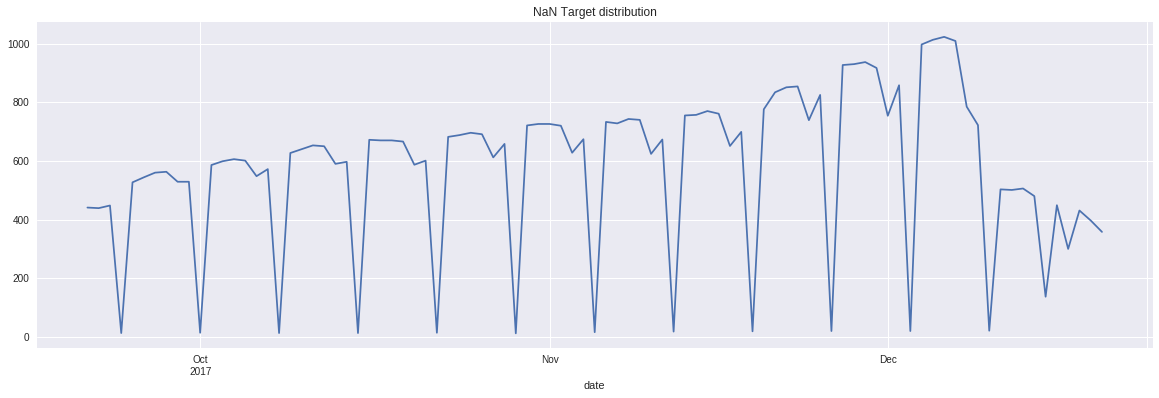

In [0]:
# Percentage of NaN target in the data
print( round(len(df.loc[df['target']==''])*1.00 /len(df), 5))

# Show when are NaN target distributed
df.loc[df['target']==''].groupby('date')['target'].count().plot(figsize=(20,6), title='NaN Target distribution')
plt.show()
# It seems that the NaN target are somewhat evently distributed over the time range

Why are there so many NaN targets? <br>
Why do they appear in a pattern?

In [0]:
# simply exclude all rows with NaN targets
df2 = df.dropna(axis=0, subset=['target'])
df2['target'] = pd.to_numeric(df2['target'])
df2 = df2.loc[df2['target']>1]
df2['goal_achievement'] = df2['steps']/df2['target']
df2.head()

,date,id,isXmas,isnew,precip,steps,target,temp,tempdiff,week,goal_achievement
452,2017-09-22,72950af6-9532-404a-85b1-3fb10ac8e341,0,0,0.254,4382,7000.0,12.2,-2,38,0.626000
458,2017-09-22,f8704169-fc8d-41b5-80b0-278291c36c81,0,0,0.254,12595,9000.0,12.2,-2,38,1.399444
469,2017-09-22,701f162a-97bf-4e76-b3dd-bfbcada86843,0,0,0.254,702,8000.0,12.2,-2,38,0.087750
472,2017-09-22,c03d6fbc-70a4-4548-9048-e7dedd9bfbca,0,0,0.254,27498,10000.0,12.2,-2,38,2.749800
476,2017-09-22,214b248e-2698-4c27-b877-83ce796d1397,0,0,0.254,11568,5000.0,12.2,-2,38,2.313600


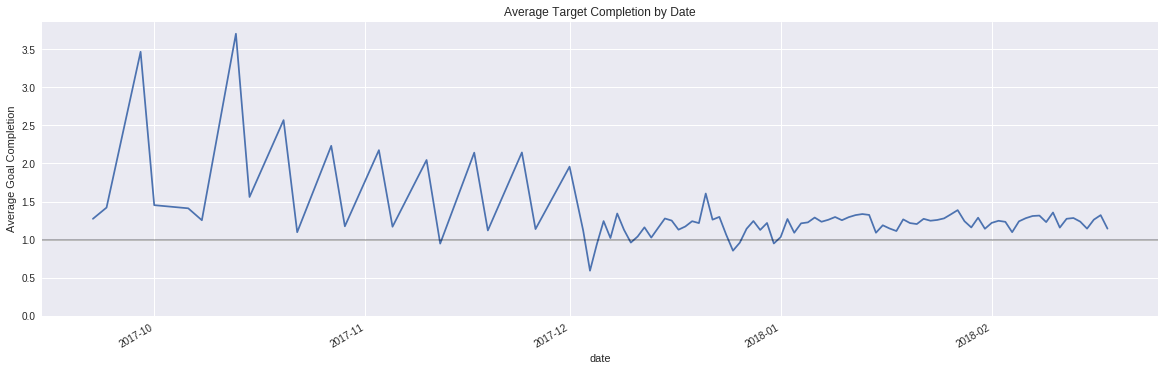

In [0]:
bx = df2.groupby('date')['goal_achievement'].mean().plot(figsize=(20,6))
bx.axhline(y=1, alpha=0.3, color='black')
bx.set_title("Average Target Completion by Date")
bx.set_ylabel("Average Goal Completion")
bx.set_ylim(0,)
plt.show()

In [0]:
plt.figure(dpi=100)
cx = df2.groupby('days_used')['goal_achievement'].mean().plot(figsize=(15,6))
cx.axhline(y=1, alpha=0.3, color='black')
cx.set_title("Average Target Completion by Date")
cx.set_ylabel("Average Goal Completion (%)")

plt.show()

KeyError: ignored

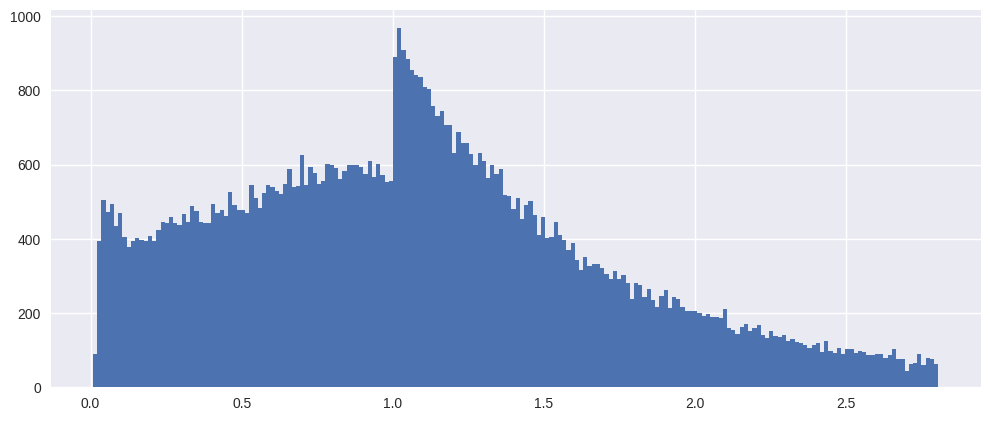

In [0]:
plt.figure(dpi=100)
q05 = df2['goal_achievement'].quantile(0.05)
q95 = df2['goal_achievement'].quantile(0.95)
df2.loc[  (df2['goal_achievement']>0) &  (df2['goal_achievement']<q95)     ]['goal_achievement'].hist(bins=200, figsize=(12,5))

In [0]:
# Check if the goal_achievement is a normal distribution
from scipy import stats
stats.mstats.normaltest(df2.loc[  (df2['goal_achievement']>q05) &  (df2['goal_achievement']<q95) ]['goal_achievement'])

NormaltestResult(statistic=3292.196690230083, pvalue=0.0)

**Autocorrelation**

/usr/local/lib/python2.7/dist-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


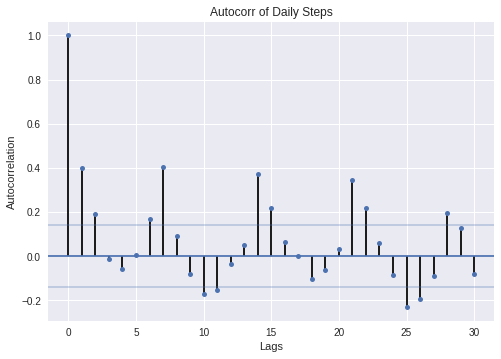

In [0]:
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf

ax = plot_acf(df.groupby('date')['steps'].mean(), alpha=1, lags=30)
plt.xlabel('Lags')
plt.ylabel('Autocorrelation')
plt.title('Autocorr of Daily Steps')
plt.axhline(y=0.14,alpha=0.3)
plt.axhline(y=-0.14,alpha=0.3)

plt.show()
# The critical values at the 5 % significance level are -0.140 and 0.140.

0508 

In [0]:
# Users' progress over time

# Old challenge

interval = import_data("interval.csv")



In [0]:
# New challenge
goal = import_data("interval.csv")


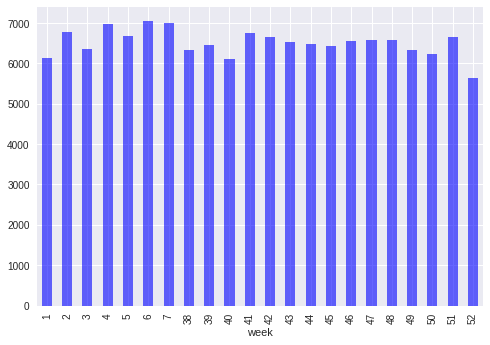

In [0]:
df.head()
df.groupby('week')['steps'].mean().plot(kind='bar', color='blue', alpha=0.6)